Читатель, прости, это слишком `1d`, оч много нужно для `2d` переписать

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Последнее достижение - 2d модель с одной жидкостью. Шаг вперёд, шаг назад. Теперь 1d с 2 жидкостями

Запишем некоторые свойства общие для резервуара

In [2]:
nx = 15
k = 1e-1 * 1.987e-13  # 1 darcy to m^2
dx = 1 # m
dy = 5 # m
phi = 0.4
p_0 = 4e4 * 6894  # psi to Pa
p = np.ones((nx, 1)) * p_0
d = 3  # m
dt = 1  # s
s_0 = 0.4
s_o = np.ones((nx, 1)) * s_0
s_w = np.ones((nx, 1))* (1 - s_0)

Перейдём к сжимаемости для [rock](https://www.sciencedirect.com/topics/engineering/formation-compressibility), [water and oil](http://www.fekete.com/san/webhelp/feketeharmony/harmony_webhelp/content/html_files/reference_material/general_concepts/reservoir_properties.htm)

In [3]:
c_w = 1e-6 # # Pa^-1
c_o = 1e-6 # # Pa^-1
c_r = 20e-6 #  Pa^-1 

Также различаются вязкости [oil](https://petrowiki.org/Oil_viscosity) и [water](http://fekete.com/SAN/TheoryAndEquations/HarmonyTheoryEquations/Content/HTML_Files/Reference_Material/General_Concepts/Reservoir_Fluid_Properties.htm)

In [4]:
B_o = 1
B_w = 1
mu_o = 1e2 / 1000 # cp to Pa * s
mu_w = 0.7 / 1000 # cp to Pa * s

Теперь напишем уравнение для одной фазы

Поток в скважину
$$q_{\alpha} = (p_{w} - p_{l}) \cdot \frac{4\pi k_{\alpha}}{B_{\alpha}\mu_{\alpha}} \cdot \frac{r_w r_{ref}}{r_w - r_{ref}}=\\
(p_{w} - p_{l}) \cdot J_l^{\alpha} k_{\alpha}
$$

Уравнение для резурвуара
$$\frac{\partial}{\partial x}\big(\frac{k k^{rel}_{\alpha} A_x}{\mu B_{\alpha}} \frac{\partial p}{\partial x}\big) \Delta x
+ q_{\alpha}
=\frac{V_b}{\alpha}\frac{\partial}{\partial t}\big(S_{\alpha}\frac{\phi}{B_{\alpha}}\big)
$$


$$\frac{\partial}{\partial t} \frac{\phi S_{\alpha}}{B_{\alpha}} = \frac{\phi}{B_{\alpha}} \frac{\partial S_{\alpha}}{\partial t} + \big( \frac{\phi S_{\alpha}}{B_{\alpha}} c_{\alpha}  + \frac{\phi S_{\alpha}}{B_{\alpha}} c_r \big) \frac{\partial p}{\partial t}$$

Домножим левую и правую части на $B_{\alpha}$

$$\frac{\partial}{\partial x}\big(\frac{k k^{rel}_{\alpha} A_x}{\mu} \frac{\partial p}{\partial x}\big) \Delta x
+ q_{\alpha} B_{\alpha}
= V_b\Big(
\phi \frac{\partial S_{\alpha}}{\partial t} + \phi \big(S_{\alpha} c_{\alpha}  + S_{\alpha} c_r \big) \frac{\partial p}{\partial t}
\Big)
$$

Сложим два этих уравнения для $\alpha$ нефть (o) и вода (w), учитывая что $S_w + S_o = 1$

$$\frac{\partial}{\partial x}\big(\big[\frac{k k^{rel}_{o} A_x}{\mu_o} + \frac{k k^{rel}_{w} A_x}{\mu_w}\big]
\frac{\partial p}{\partial x}\big) \Delta x
+ q_{o} B_{o} + q_{w} B_{w}
= V_b\Big(
0 +\phi \big(S_o c_o + S_w c_w  +1\cdot c_r \big) \frac{\partial p}{\partial t}
\Big)
$$

Добавим сюда расчёт значения расхода $q_{\alpha}$

$$\frac{\partial}{\partial x}\big(k A_x \big[\frac{k^{rel}_{o}}{\mu_o} + \frac{k^{rel}_{w}}{\mu_w}\big]
\frac{\partial p}{\partial x}\big) \Delta x + \\
(\vec{p}_{\texttt{well}} - \vec{p}) \cdot J_l^{o} k_{o} k_{o}^{rel} B_{o} + 
(\vec{p}_{\texttt{well}} - \vec{p}) \cdot J_l^{w} k_{w} k_{w}^{rel} B_{w} = \\
V_b\phi \Big(S_o c_o + S_w c_w  +c_r
\Big)\frac{\partial p}{\partial t}
$$

По сути тут опять нужно определить матрицу `lapl`, чтобы приблизить общий лапласиан с коэффициентами.
Все коэффициенты понятны, табличные величины, кроме $k_{\alpha}^{rel}$.
Все модели что я видел достаточно сложны, поэтому напишу быстренько функцию, похожую на то что есть на графиках

In [5]:
def k_rel_w(s):
    trh_b = 0.2
    trh_t = 0.6
    mult = 3
    out = 0
    if s < trh_b:
        out = 0
    elif s < trh_t:
        out = (s - trh_b) ** 2
    else:
        out = (trh_t - trh_b) ** 2
    return out * mult


def k_rel_o(s):
    trh_b = 0.2
    trh_t = 0.8
    mult = 2
    out = 0
    if s < trh_b:
        out = 0
    elif s < trh_t:
        out = (s - trh_b) ** 2
    else:
        out = (trh_t - trh_b) ** 2
    return out * mult

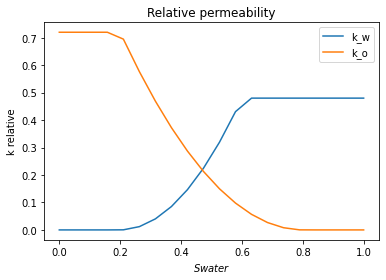

In [6]:
ss = np.linspace(0, 1, 20)
k_rels_w = [k_rel_w(s) for s in ss]
k_rels_o = [k_rel_o(1 - s) for s in ss]
plt.plot(ss, k_rels_w, label='k_w')
plt.plot(ss, k_rels_o, label='k_o')
plt.xlabel('$S water$')
plt.ylabel("k relative")
plt.title('Relative permeability')
plt.legend()
plt.show()

В этой модели будем учитывать, что при перетекании жидкости из ячеек берётся $k^{\texttt{rel}^{\alpha}}(S\texttt{[i,j]})$ той ячейки, где больше давление.
Пока ограничимся равномерным распределением permeability.

In [7]:
class ResState:
    def __init__(self, values, bound_value):
        self.values = values
        self.bound_v = bound_value
        self.shape = values.shape
    def __getitem__(self, item):
        i, j = item
        if (i < 0) | (j < 0) | (i >= self.shape[0]) | (j >= self.shape[0]):
            return self.bound_v
        else:
            return self.values[i, j]

In [8]:
p = ResState(p, p_0)
s_o = ResState(s_o, s_0)
s_w = ResState(s_w, 1 - s_0)

In [9]:
def k_rel_o_p(i, j, s, p):
    if p[i, 0] > p[j, 0]:
        out =  k_rel_o(s[i, 0])
    else:
        out = k_rel_o(s[j, 0])
    return out


def k_rel_w_p(i, j, s, p):
    if p[i, 0] > p[j, 0]:
        out =  k_rel_w(s[i, 0])
    else:
        out = k_rel_w(s[j, 0])
    return out


def k_rel_ph(i, j, s, p, ph):
    out = 0       
        
    if ph == 'o':
        out = k_rel_o_p(i, j, s, p)
    elif ph == 'w':
        out = k_rel_w_p(i, j, s, p)
    return out

Ну что, быстренько заполним матрицу для расчёта лапласиана

$$A_x \Big(\frac{\big[\frac{k k^{rel}_{o}}{\mu_o} + \frac{k k^{rel}_{w}}{\mu_w}\big]_{i-\frac{1}{2}}}{\Delta x_{i-\frac{1}{2}}}p_{i-1}
- \big( \frac{\big[\frac{k k^{rel}_{o}}{\mu_o} + \frac{k k^{rel}_{w}}{\mu_w}\big]_{i+\frac{1}{2}}}
{\Delta x_{i+\frac{1}{2}}} + 
\frac{\big[\frac{k k^{rel}_{o}}{\mu_o} + \frac{k k^{rel}_{w}}{\mu_w}\big]_{i-\frac{1}{2}}}{\Delta x_{i-\frac{1}{2}}}\big)p_{i}
+\frac{\big[\frac{k k^{rel}_{o}}{\mu_o} + \frac{k k^{rel}_{w}}{\mu_w}\big]_{i+\frac{1}{2}}}{\Delta x_{i+\frac{1}{2}}}p_{i+1}\Big) + \\
+ (\vec{p}_{\texttt{well}} - \vec{p}) \cdot J^{o} k_{o} k_{o}^{rel} B_{o} + 
(\vec{p}_{\texttt{well}} - \vec{p}) \cdot J^{w} k_{w} k_{w}^{rel} B_{w}=\\
=\phi \big(S_o c_o + S_w c_w  +1\cdot c_r \big) \frac{p^{n+1}_i - p^{n}_i}{\Delta t}
$$

В уравнении лапласиан можно представить как сумму двух, для воды и нефти.
Так и будем их реализовывать.

In [10]:
def get_lapl_one_ph(p, s, mu, k, d, dx, dy, ph):
    lapl = np.zeros((nx, nx))
    for dia in range(nx):        
        lapl[dia, dia] += k_rel_ph(dia, dia-1, s, p, ph) / mu / dx
        lapl[dia, dia] += k_rel_ph(dia, dia+1, s, p, ph) / mu / dx
        if dia-1 >= 0:
            lapl[dia, dia-1] += k_rel_ph(dia, dia-1, s, p, ph) / mu / dx
        if dia+1 < nx:
            lapl[dia, dia+1] += k_rel_ph(dia, dia-1, s, p, ph) / mu / dx
    lapl *= d * dy
    return lapl

In [11]:
lapl_w = get_lapl_one_ph(p, s_o, mu_w, k, d, dx, dy, 'w')
lapl_o = get_lapl_one_ph(p, s_w, mu_o, k, d, dx, dy, 'o')

Также нужны граничные условия для этого лапласиана

In [12]:
q_tilde_w = np.zeros((nx, 1))
q_tilde_w[0][0] = k_rel_ph(0, -1, s_w, p,'w') / mu_w / dx * d * dy * p_0
q_tilde_w[nx-1][0] = k_rel_ph(0, nx, s_w, p, 'w') / mu_w / dx * d * dy * p_0

q_tilde_w = np.zeros((nx, 1))
q_tilde_w[0][0] = k_rel_ph(0, -1, s_o, p, 'o') / mu_o / dx * d * dy * p_0
q_tilde_w[nx-1][0] = k_rel_ph(0, nx, s_o, p, 'o') / mu_o / dx * d * dy * p_0

Так, ещё уделим внимание получению расхода
$$
q = 
(\vec{p}_{\texttt{well}} - \vec{p}) \cdot J^{o} k_{o} k_{o}^{rel} B_{o} + 
(\vec{p}_{\texttt{well}} - \vec{p}) \cdot J^{w} k_{w} k_{w}^{rel} B_{w} = \\
=  - \big(J^{o} k_{o} k_{o}^{rel} B_{o} +  J^{w} k_{w} k_{w}^{rel} B_{w}\big) \vec{p}  + \\
+ \big(J^{o} k_{o} k_{o}^{rel} B_{o} +  J^{w} k_{w} k_{w}^{rel} B_{w}\big) \vec{p}_{\texttt{well}} = \\
- \big( J_w(S_w) + J_o(S_o)\big) \vec{p} + \big( J_w(S_w) + J_o(S_o)\big) \vec{p}_{\texttt{well}}
$$

$$
J_{\alpha}\big(S_{\alpha}\big) = \frac{4\pi}{B_{\alpha} \mu_{\alpha}} \frac{r_{\texttt{ref}}r_{\texttt{well}}}{r_{\texttt{ref}}+r_{\texttt{well}}} \cdot k_{\alpha}^{\texttt{rel}}
$$